This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html).

In [47]:
%pip install -e ..
# %pip install scikit-optimize

Obtaining file:///home/rstudio/rl4fisheries
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for rl4fisheries (pyproject.toml) ... done
  Created wheel for rl4fisheries: filename=rl4fisheries-1.0.0-0.editable-py3-none-any.whl size=2176 sha256=aebb65ca4f07d99d588c7fb0de18b7cdbb9aff0bb29ab44fe3dd315eb92caf22
  Stored in directory: /tmp/pip-ephem-wheel-cache-t5m_i4it/wheels/d3/ce/fe/d5af67bb4edf309f6a59d59140b2b78d5a336b2ad4b93a1fb4
Successfully built rl4fisheries
  Attempting uninstall: rl4fisheries
    Found existing installation: rl4fisheries 1.0.0
    Uninstalling rl4fisheries-1.0.0:
      Successfully uninstalled rl4fisheries-1.0.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Using skopt

In [9]:
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_objective

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from rl4fisheries import Asm, Asm2o, Msy, ConstEsc, CautionaryRule
import numpy as np

## MSY (Constant Mortality)

In [2]:
env = Asm()
def msy_fun(x):
    agent = Msy(mortality=x[0])
    mean, sd = evaluate_policy(agent, Monitor(env), n_eval_episodes=100)
    return -mean

In [3]:
%%time
msy_gp = gp_minimize(msy_fun, [(0.002, 0.25)], n_calls = 100, verbose=True, n_jobs=-1)
msy_gp.fun, msy_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.1018
Function value obtained: -29.5673
Current minimum: -29.5673
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1198
Function value obtained: -29.0363
Current minimum: -29.5673
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0984
Function value obtained: -8.2585
Current minimum: -29.5673
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.0947
Function value obtained: -4.3467
Current minimum: -29.5673
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0949
Function value obtained: -18.4655
Current minimum: -29.5673
Iteration No: 6 s

/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 461 ended. Search finished for the next optimal point.
Time taken: 13.5517
Function value obtained: -47.8013
Current minimum: -62.0848
Iteration No: 462 started. Searching for the next optimal point.
Iteration No: 462 ended. Search finished for the next optimal point.
Time taken: 13.6241
Function value obtained: -45.2473
Current minimum: -62.0848
Iteration No: 463 started. Searching for the next optimal point.
Iteration No: 463 ended. Search finished for the next optimal point.
Time taken: 13.8598
Function value obtained: -41.5950
Current minimum: -62.0848
Iteration No: 464 started. Searching for the next optimal point.
Iteration No: 464 ended. Search finished for the next optimal point.
Time taken: 13.4720
Function value obtained: -55.2877
Current minimum: -62.0848
Iteration No: 465 started. Searching for the next optimal point.
Iteration No: 465 ended. Search finished for the next optimal point.
Time taken: 13.9496
Function value obtained: -37.7770
Current minimum: -62.

/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 491 ended. Search finished for the next optimal point.
Time taken: 14.9142
Function value obtained: -41.1283
Current minimum: -62.0848
Iteration No: 492 started. Searching for the next optimal point.
Iteration No: 492 ended. Search finished for the next optimal point.
Time taken: 14.9688
Function value obtained: -47.3437
Current minimum: -62.0848
Iteration No: 493 started. Searching for the next optimal point.
Iteration No: 493 ended. Search finished for the next optimal point.
Time taken: 15.2509
Function value obtained: -38.7203
Current minimum: -62.0848
Iteration No: 494 started. Searching for the next optimal point.
Iteration No: 494 ended. Search finished for the next optimal point.
Time taken: 15.0143
Function value obtained: -42.6341
Current minimum: -62.0848
Iteration No: 495 started. Searching for the next optimal point.
Iteration No: 495 ended. Search finished for the next optimal point.
Time taken: 15.0975
Function value obtained: -41.0785
Current minimum: -62.

(-62.08484130000001, [0.058590822346937174])

In [4]:
%%time
msy_gbrt = gbrt_minimize(msy_fun, [(0.02, 0.15)], n_calls = 100, verbose=True, n_jobs=-1)
msy_gbrt.fun, msy_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.0914
Function value obtained: -29.0648
Current minimum: -29.0648
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.0919
Function value obtained: -43.3516
Current minimum: -43.3516
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0924
Function value obtained: -43.5100
Current minimum: -43.5100
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.0973
Function value obtained: -46.0853
Current minimum: -46.0853
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0984
Function value obtained: -42.9894
Current minimum: -46.0853
Iteration No: 6

/opt/venv/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 1.2440
Function value obtained: -39.6403
Current minimum: -57.1683
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.2345
Function value obtained: -21.5861
Current minimum: -57.1683
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.2316
Function value obtained: -42.6638
Current minimum: -57.1683
Iteration No: 46 started. Searching for the next optimal point.
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 1.2640
Function value obtained: -21.5203
Current minimum: -57.1683
Iteration No: 47 started. Searching for the next optimal point.
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 1.2433
Function value obtained: -41.4619
Current minimum: -57.1683
Iteration

(-57.168266599999995, [0.05811506272614242])

<Axes: xlabel='$X_{0}$', ylabel='Partial dependence'>

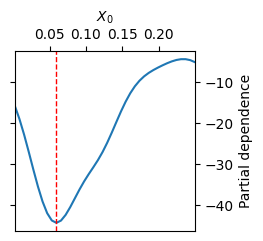

In [27]:
plot_objective(msy_gp)

## Const Escapement

In [5]:
def esc_fun(x):
    agent = Msy(mortality=x[0])
    mean, sd = evaluate_policy(agent, Monitor(env), n_eval_episodes=100)
    return -mean

In [6]:
%%time
esc_gp = gp_minimize(esc_fun, [(0.002, 0.25)], n_calls = 500, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.1125
Function value obtained: -3.9773
Current minimum: -3.9773
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.1054
Function value obtained: -38.1530
Current minimum: -38.1530
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.1181
Function value obtained: -21.7307
Current minimum: -38.1530
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.1157
Function value obtained: -36.2086
Current minimum: -38.1530
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.1056
Function value obtained: -24.0937
Current minimum: -38.1530
Iteration No: 6 s

(-54.8142164, [0.05693229984265447])

In [7]:
%%time
esc_gbrt = gbrt_minimize(esc_fun, [(0.02, 0.15)], n_calls = 100, verbose=True, n_jobs=-1)
esc_gbrt.fun, esc_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.0969
Function value obtained: -43.7686
Current minimum: -43.7686
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.0963
Function value obtained: -46.2158
Current minimum: -46.2158
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0913
Function value obtained: -41.6384
Current minimum: -46.2158
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.0988
Function value obtained: -38.1748
Current minimum: -46.2158
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.0932
Function value obtained: -30.8152
Current minimum: -46.2158
Iteration No: 6

(-54.552704199999994, [0.05755569926168816])

<Axes: xlabel='$X_{0}$', ylabel='Partial dependence'>

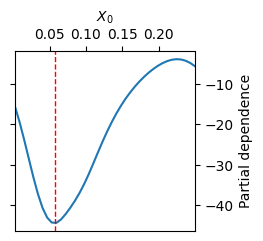

In [26]:
plot_objective(esc_gp)

## Precationary Rule (piecewise linear)

In [10]:
from skopt.space import Real
from skopt.utils import use_named_args

space  = [Real(0.00001, 1, name='radius'),
          Real(0.00001, np.pi/4.00001, name='theta'),
          Real(0, 0.2, name='y2')]

@use_named_args(space)
def g(**params):

    theta = params["theta"]
    radius = params["radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    
    assert x1 <= x2, ("CautionaryRule error: x1 < x2, " + str(x1) + ", ", str(x2) )

    agent = CautionaryRule(x1 = x1, x2 =  x2, y2 = params["y2"])
    mean, sd = evaluate_policy(agent, Monitor(env), n_eval_episodes=100)
    return -mean        


In [11]:
%%time
g_gp = gp_minimize(g, space, n_calls = 300, verbose=True, n_jobs=-1)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.0631
Function value obtained: -11.1922
Current minimum: -11.1922
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.6792
Function value obtained: -7.5372
Current minimum: -11.1922
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.6676
Function value obtained: -43.8100
Current minimum: -43.8100
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.6998
Function value obtained: -14.2469
Current minimum: -43.8100
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.6204
Function value obtained: -8.4166
Current minimum: -43.8100
Iteration No

(-64.06042883, [0.041136645707627796, 0.7853961999069485, 0.12010362758045579])

In [12]:
%%time
g_gbrt = gbrt_minimize(g, space, n_calls = 300, verbose=True, n_jobs=-1)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.6798
Function value obtained: -17.7134
Current minimum: -17.7134
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 11.6132
Function value obtained: -35.0209
Current minimum: -35.0209
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 11.4436
Function value obtained: -4.6572
Current minimum: -35.0209
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.6489
Function value obtained: -11.3697
Current minimum: -35.0209
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 11.9656
Function value obtained: -24.4783
Current minimum: -35.0209
Iteration N

(-64.49868469, [0.06184391109700299, 0.3296309210963565, 0.12990125226898555])

In [14]:
g_gp.fun, g_gp.x, g_gbrt.fun, g_gbrt.x

(-64.06042883,
 [0.041136645707627796, 0.7853961999069485, 0.12010362758045579],
 -64.49868469,
 [0.06184391109700299, 0.3296309210963565, 0.12990125226898555])

In [22]:
res = g_gp

radius = res.x[0]
theta = res.x[1]
y2 = res.x[2]
x1 = np.sin(theta) * radius
x2 = np.cos(theta) * radius

agent = CautionaryRule(x1, x2, y2)
evaluate_policy(agent, Monitor(env), n_eval_episodes=100)


(61.346940599999996, 14.639097133690518)

array([[<Axes: xlabel='radius', ylabel='Partial dependence'>, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='theta'>,
        <Axes: xlabel='theta', ylabel='Partial dependence'>, <Axes: >],
       [<Axes: xlabel='radius', ylabel='y2'>, <Axes: xlabel='theta'>,
        <Axes: xlabel='y2', ylabel='Partial dependence'>]], dtype=object)

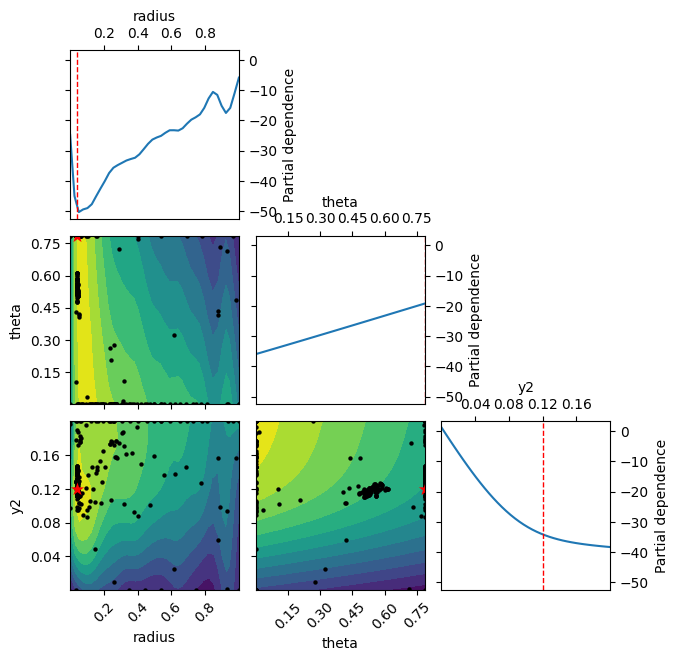

In [23]:
plot_objective(g_gp)